In [12]:
import pandas as pd
import numpy as np
import PIL as pil
from PIL import Image as img
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil
import sys
import yaml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pydot
import graphviz

In [13]:
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [14]:
sys.path.insert(0, os.path.abspath(config['lib']))

In [19]:
image_size = (512, 512)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    (config['data']['clean']),
    validation_split=0.3,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20026 files belonging to 2 classes.
Using 14019 files for training.
Using 6007 files for validation.


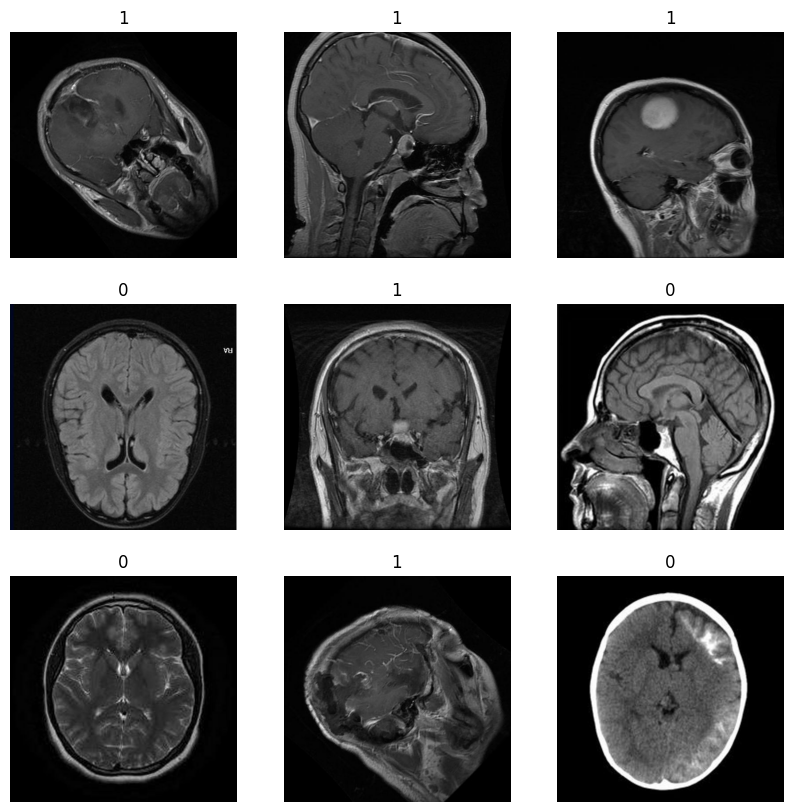

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

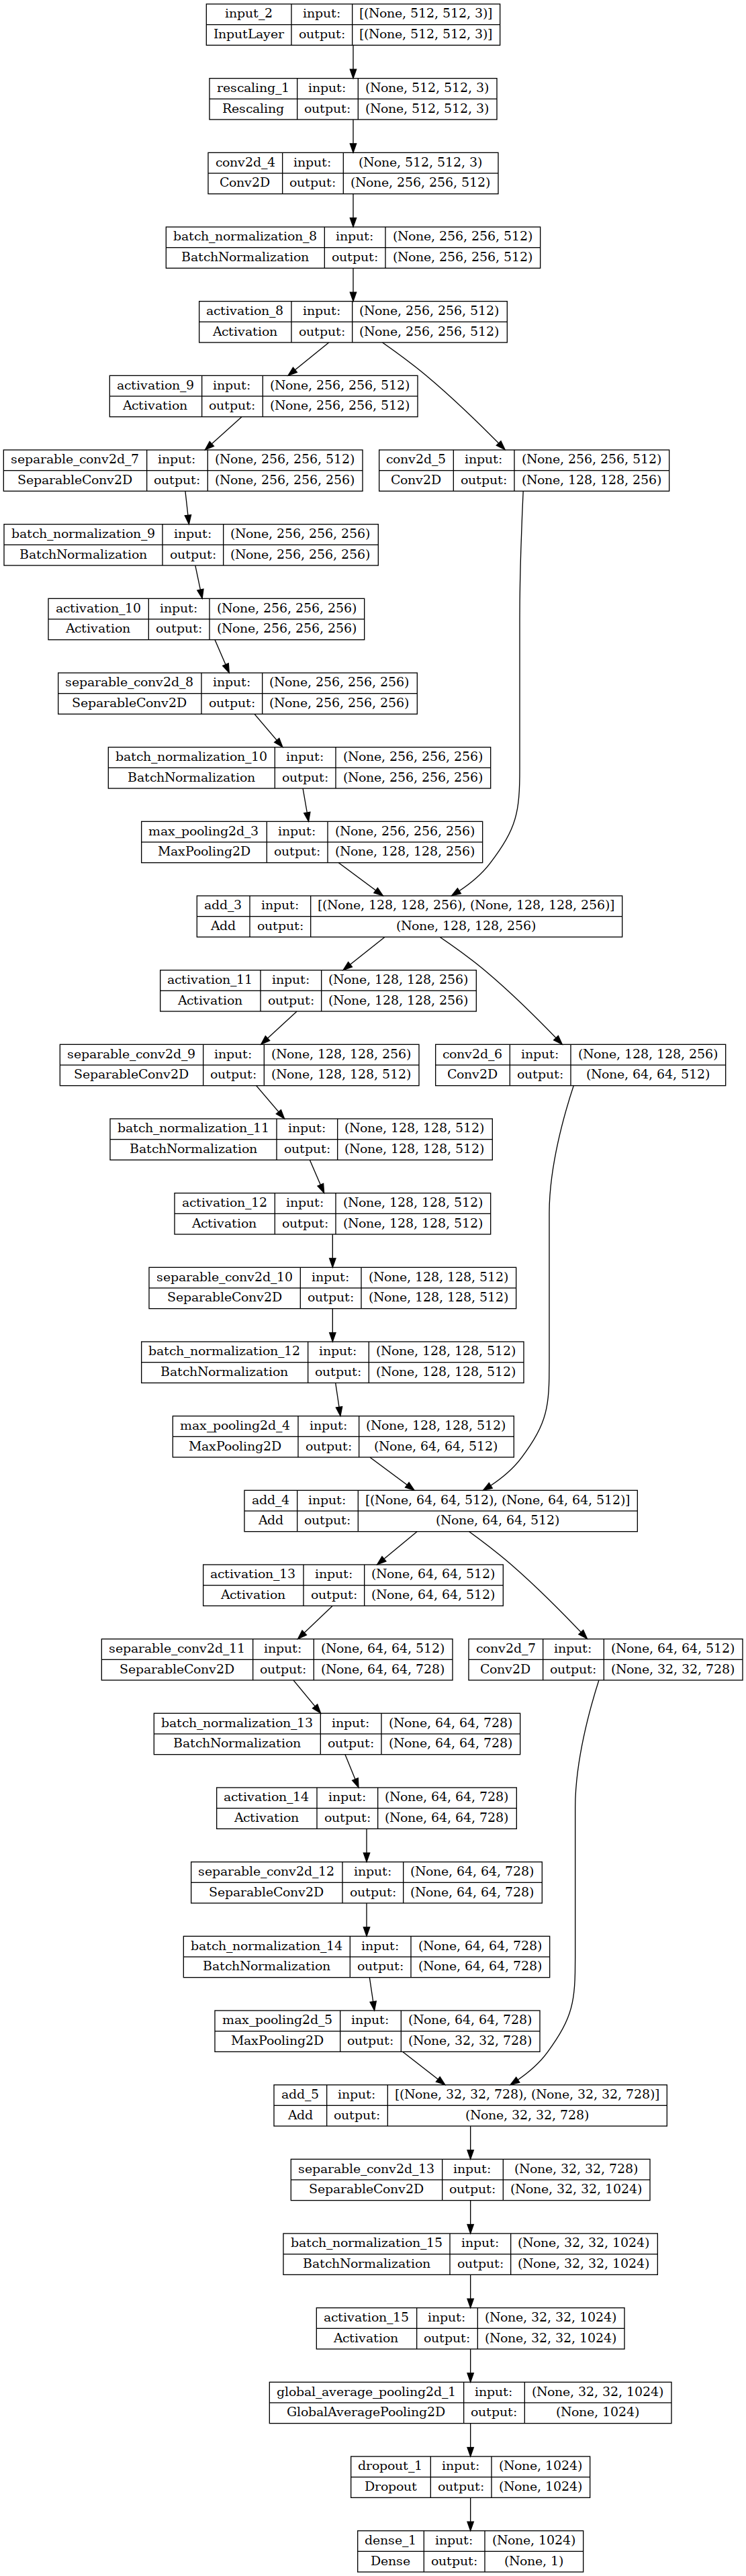

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
